In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

plt.style.use("ggplot")

In [2]:
# First time data load.
interactions = pd.read_csv(os.path.join("..", "..", "data", "mts_library", "interactions.csv"))
items = pd.read_csv(os.path.join("..", "..", "data", "mts_library", "items.csv")) 
users = pd.read_csv(os.path.join("..", "..", "data", "mts_library", "users.csv"))

In [3]:
# Modify rating timestamp format
interactions['start_date'] = pd.to_datetime(interactions['start_date'])

In [4]:
interactions.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [5]:
# Check NaN values
interactions.isnull().sum()

user_id             0
item_id             0
progress            0
rating        1247722
start_date          0
dtype: int64

In [6]:
# Process dublicates
# Find duplicates based on 'user_id' and 'item_id'
duplicates = interactions.duplicated(subset=['user_id', 'item_id'], keep=False)

# Create separate dataframe to process dublicates
df_duplicates = interactions[duplicates].sort_values(by=['user_id', 'start_date'])

# Remove the duplicates from the original dataframe
interactions = interactions[~duplicates]

# Aggregate the duplicate rows by grouping on 'user_id' and 'item_id'
df_duplicates = df_duplicates.groupby(['user_id', 'item_id']).agg({
    'progress': 'max',
    'rating': 'max',
    'start_date': 'min'
}).reset_index()

# Append the aggregated duplicates to the original dataframe
interactions = pd.concat([interactions, df_duplicates], ignore_index=True)

In [25]:
# Some values
print(f"Amount of interactions - {interactions.shape[0]}")
print(f"Amount of the NaN ratings - {interactions['rating'].isna().sum()}")
print(f"Unique users with features - {users.shape[0]}")
print(f"Unique items with features - {items.shape[0]}")
print(f"Unique users with interactions - {interactions.user_id.nunique()}")
print(f"Unique items with interactions - {interactions.item_id.nunique()}")

Amount of interactions - 1532998
Amount of the NaN ratings - 1247643
Unique users with features - 142888
Unique items with features - 59599
Unique users with interactions - 151600
Unique items with interactions - 59599


## Statistics

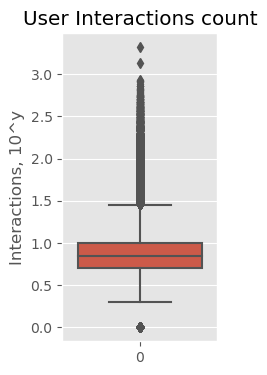

Median number of Interactions per user: 7.0


In [50]:
# Count the number of rows for each userId
user_interactions = interactions.groupby('user_id')['item_id'].count().values
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(np.log10(user_interactions))
plt.ylabel("Interactions, 10^y")
plt.title("User Interactions count")
plt.show()

print("Median number of Interactions per user:", np.median(user_interactions))

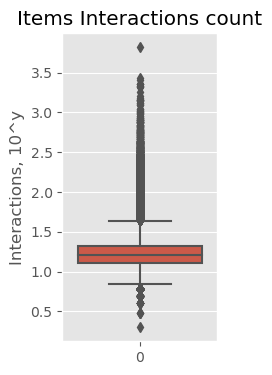

Median number of Interactions per user: 16.0


In [53]:
# Count the number of rows for each userId
items_interactions = interactions.groupby('item_id')['user_id'].count().values
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(np.log10(items_interactions))
plt.ylabel("Interactions, 10^y")
plt.title("Items Interactions count")
plt.show()

print("Median number of Interactions per user:", np.median(items_interactions))

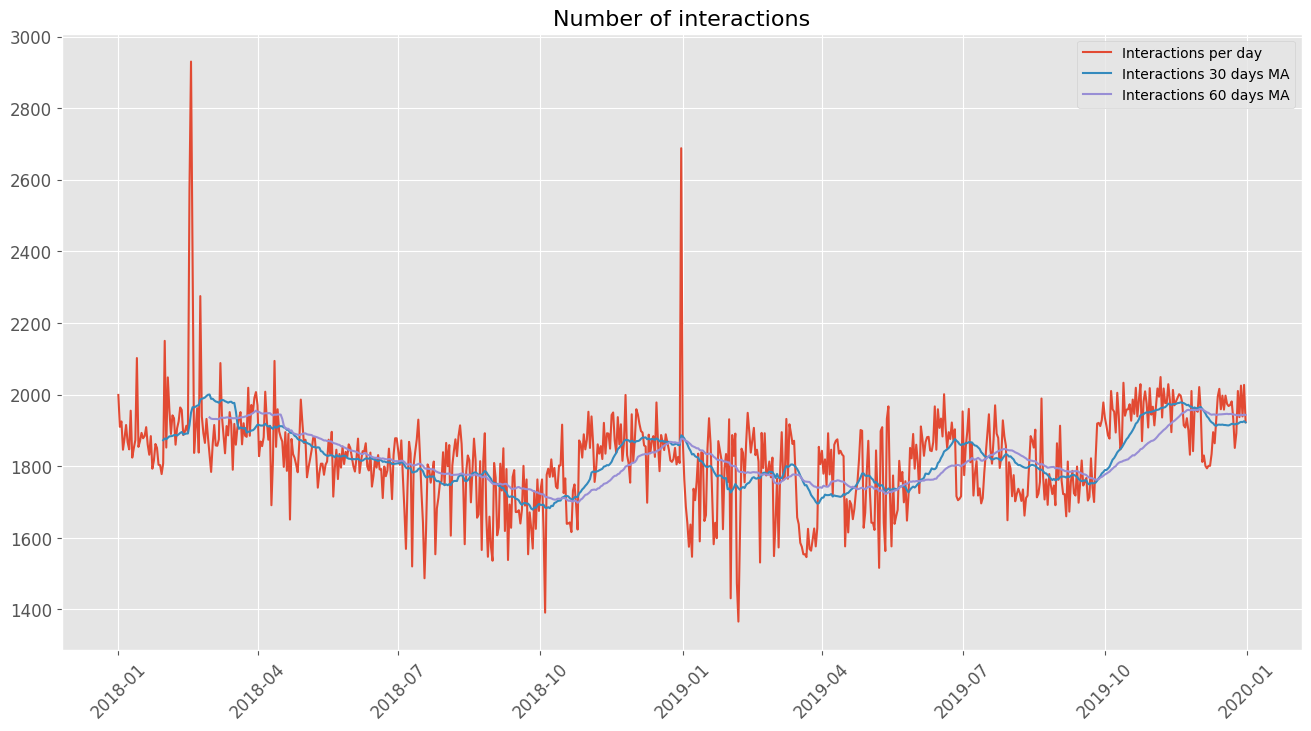

In [34]:
# Lets check how interactions are spread in time
interactions_by_date = interactions.groupby('start_date')['item_id'].count()
plt.figure(figsize=(16, 8))

plt.plot(interactions_by_date, label="Interactions per day")
plt.plot(interactions_by_date.rolling(30).mean(), label="Interactions 30 days MA");
plt.plot(interactions_by_date.rolling(60).mean(), label="Interactions 60 days MA");

plt.title('Number of interactions', size=16)

plt.yticks(size=12)
plt.xticks(size=12, rotation=45)
plt.legend();

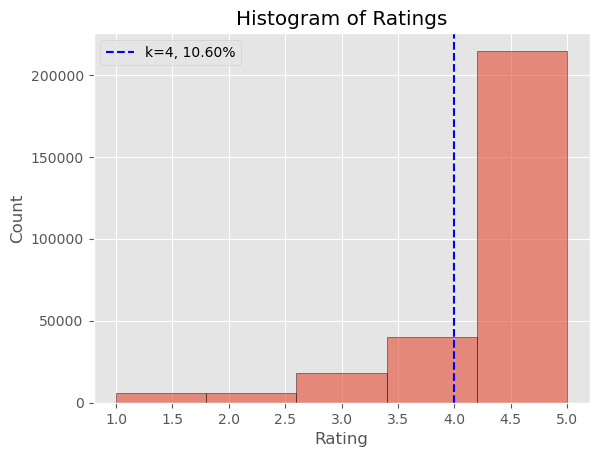

In [99]:
# Filter NaN ratings and calculate % less than 4
ratings = interactions[~interactions["rating"].isnull()]
percentage_less_than_k = len(ratings[ratings['rating'] < 4]) / len(ratings) * 100
# Plot the histogram of ratings
plt.hist(interactions["rating"], bins=5, edgecolor="black", alpha=0.6)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings")
plt.axvline(x=4, color="blue", linestyle="--", label=f"k={4}, {percentage_less_than_k:.2f}%")
plt.legend()
plt.show()

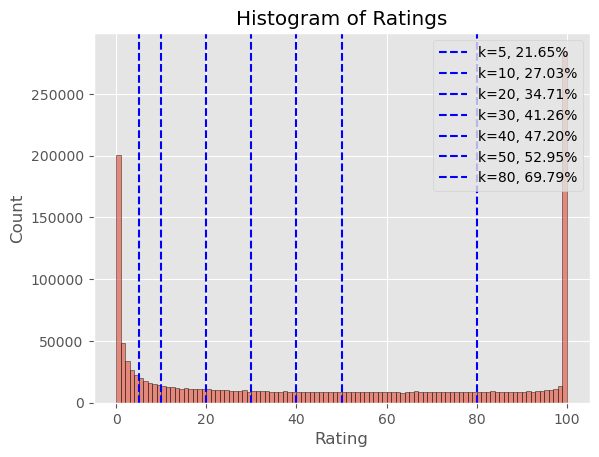

In [100]:
# Plot the histogram of progress
# Create a list of k values
k_values = [5, 10, 20, 30, 40, 50, 80]

# Plot the histogram
plt.hist(interactions["progress"], bins=100, edgecolor="black", alpha=0.6)

for k in k_values:
    # Count the number of ratings less than k
    num_ratings_less_than_k = len(interactions[interactions["progress"] < k])

    # Calculate the total number of ratings
    total_ratings = len(interactions)

    # Calculate the percentage
    percentage_less_than_k = (num_ratings_less_than_k / total_ratings) * 100

    # Plot the vertical line for k
    plt.axvline(
        x=k, color="blue", linestyle="--", label=f"k={k}, {percentage_less_than_k:.2f}%"
    )

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings")
plt.legend()
plt.show()

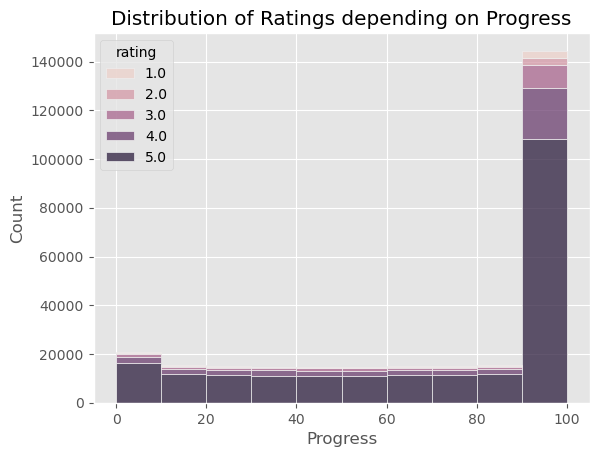

In [98]:
# Lets check if ratings depend on progress
sns.histplot(data=ratings, x='progress', hue='rating', multiple='stack', bins=10)
plt.xlabel('Progress')
plt.ylabel('Count')
plt.title('Distribution of Ratings depending on Progress')
plt.show()

We can see from the histogram that ratings do not depend on progress.
Items with 0 progress have ratings as well. 
This possibly mean that user could read book in another platform and rated it there.

### How to use interactions and ratings?
- interactions - percentage of book read by user
- rating in range 1 to 5, only 20% of interactions have ratings

One may use all interactions and percentage as weight. 

From another point of view, we can filter interactions with low ratings or with low percentage of progress without rating to make the data implicit (no negative experience).